In [1]:
import os
from tqdm.notebook import tqdm
import gc
from torch.nn import Parameter
import torch.nn.functional as F
import torch.nn as nn
import math
import timm
import pandas as pl
import torch
import numpy as np
from torch.amp import GradScaler
import cv2
import random
from tqdm.notebook import tqdm
from torch.autograd import Variable
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import segmentation_models_pytorch as smp
import albumentations as A
import imgaug

/home/gotheartem/Projects/ioai-hw/.venv/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def seed_everything(seed):
    random.seed(seed)
    imgaug.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(228)

In [3]:
train_msk = np.load('data/msk_array.npy')
train_images = sorted(os.listdir('data/data/train'))
test_images = sorted(os.listdir('data/data/test'))
test_msk = np.zeros((len(test_images), train_msk.shape[1], train_msk.shape[2]))

train_images = [f'data/data/train/{path}' for path in train_images]
test_images = [f'data/data/test/{path}' for path in test_images]
len(train_images)

545

In [4]:
# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, path_image, msks, train=False):

#         self.path_image = path_image
#         self.msks = msks
#         self.train = train
#         # Resize input image
#         self.image_size = 640

#     def resize(self, img, interp):
#         return  cv2.resize(
#             img, (self.image_size, self.image_size), interpolation=interp)

#     def __len__(self):
#         return len(self.path_image)

#     def __getitem__(self, i):

#         img = cv2.imread(self.path_image[i])
#         msk = self.msks[i]
#         msk = msk[:, :, None]

#         if self.train:
#             M = np.float32([
#                 [1, 0, -25],
#                 [0, 1, -25]
#             ])
#             msk=cv2.warpAffine(msk, M, (msk.shape[1], msk.shape[0]))

#             # Crop 20px from the left and top
#             img = img[25:, 25:, :]
#             msk = msk[25:, 25:]

#         img = cv2.resize(
#             img, (self.image_size, self.image_size), interpolation= cv2.INTER_LINEAR)
#         msk = cv2.resize(
#             msk, (self.image_size, self.image_size), interpolation= cv2.INTER_LINEAR)

#         img = (img / 255.) - 0.5
#         img = np.transpose(img,(2, 0, 1)).astype(np.float32)
#         img = torch.from_numpy(img)
#         msk = torch.from_numpy(msk)

#         return img, msk


In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, path_image, msks, train=False, augment=False):

        self.path_image = path_image
        self.msks = msks
        self.train = train
        self.augment = augment
        # Resize input image
        self.image_size = 640

        if self.augment:
            self.gaugmentations = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5)
            ], additional_targets={'mask': 'mask'})

            self.phaugmentations = A.Compose([
                A.CLAHE(p=0.4),
                A.RandomBrightnessContrast(p=0.4),
                A.RandomFog(fog_coef_range=(0.1, 0.3), alpha_coef=0.08, p=0.4),
                A.RandomSunFlare(flare_roi=(0, 0, 1, 1), num_flare_circles=3, src_radius=400, p=0.4)
            ])
        
        self.normalisation = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

    def resize(self, img, interp):
        return  cv2.resize(
            img, (self.image_size, self.image_size), interpolation=interp)

    def __len__(self):
        if self.augment:
            return len(self.path_image) * 3
        else:
            return len(self.path_image)

    def __getitem__(self, i):
        img = cv2.imread(self.path_image[i % len(self.path_image)])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        msk = self.msks[i % len(self.path_image)]
        msk = msk[:, :, None]

        if self.train:
            M = np.float32([
                [1, 0, -25],
                [0, 1, -25]
            ])
            msk=cv2.warpAffine(msk, M, (msk.shape[1], msk.shape[0]))

            crop = A.Compose([
                A.Crop(x_min=0, y_min=0, x_max=self.image_size - 25, y_max=self.image_size - 25, p=1.0)
            ], additional_targets={'mask': 'mask'})

            transformed = crop(image=img, mask=msk)
            img, msk = transformed['image'], transformed['mask']

            if self.augment and (i // len(self.path_image) > 0):
                augmented = self.gaugmentations(image=img, mask=msk)
                img, msk = augmented['image'], augmented['mask']

                img = self.phaugmentations(image=img)['image']

        img = cv2.resize(
            img, (self.image_size, self.image_size), interpolation= cv2.INTER_LINEAR)
        msk = cv2.resize(
            msk, (self.image_size, self.image_size), interpolation= cv2.INTER_LINEAR)

        img = self.normalisation(image=img)['image']

        img = np.transpose(img,(2, 0, 1)).astype(np.float32)
        img = torch.from_numpy(img)
        msk = torch.from_numpy(msk)

        return img, msk


In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.unet = smp.Unet('resnet34', #efficientnet-b2
                             encoder_weights='imagenet',
                             classes=1,
                             decoder_channels=[512, 256, 128, 64, 32],
        )
    def forward(self, x):
        y = self.unet(x)
        return y

In [7]:
gc.collect()
torch.cuda.empty_cache()

batch_size = 16
valid_batch_size = 4
epochs = 20
lr = 3e-4
clip_grad_norm = 16.0
DEVICE = 'cuda'
params_train = {'batch_size': batch_size, 'shuffle': True, 'drop_last': True, 'num_workers': 2}
params_val = {'batch_size': batch_size, 'shuffle': False, 'drop_last': False, 'num_workers': 2}


train_loader = torch.utils.data.DataLoader(Dataset(train_images[:-70], train_msk[:-70], train=True, augment=True), **params_train)
val_loader = torch.utils.data.DataLoader(Dataset(train_images[-70:], train_msk[-70:], train=True, augment=False), **params_val)

model = Model().cuda()
num_train_steps = int(len(train_loader) / batch_size  * epochs)
loss_func= smp.losses.DiceLoss(mode="binary", smooth=1.)

scaler = GradScaler('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr, weight_decay=0.005)#, weight_decay=0.01
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader) * epochs, 1e-7)
for epoch in range(epochs):
    model.train()
    average_loss = 0
    tk0 = tqdm(enumerate(train_loader), total = len(train_loader))
    for batch_number,  (img, target)  in tk0:
        optimizer.zero_grad()
        img = img.to(DEVICE)
        target = target.to(DEVICE)
        # continue
        with torch.amp.autocast('cuda'):
            outputs = model(img)
            loss = loss_func(outputs, target)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        average_loss += loss.cpu().detach().numpy()
        tk0.set_postfix(loss=average_loss / (batch_number + 1),lr = scheduler.get_last_lr()[0], stage="train", epoch = epoch)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for img, target in val_loader:
            img = img.to(DEVICE)
            target = target.to(DEVICE)
            
            with torch.amp.autocast('cuda'):
                outputs = model(img)
                loss = loss_func(outputs, target)
                val_loss += loss.cpu().detach().numpy()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")

/tmp/ipykernel_3648786/2220517677.py:22: UserWarning: Argument(s) 'num_flare_circles' are not valid for transform RandomSunFlare
  A.RandomSunFlare(flare_roi=(0, 0, 1, 1), num_flare_circles=3, src_radius=400, p=0.4)


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1/20, Validation Loss: 0.2480


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2/20, Validation Loss: 0.2229


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3/20, Validation Loss: 0.2045


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4/20, Validation Loss: 0.2018


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5/20, Validation Loss: 0.2046


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6/20, Validation Loss: 0.2035


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7/20, Validation Loss: 0.1942


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8/20, Validation Loss: 0.1978


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9/20, Validation Loss: 0.2016


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10/20, Validation Loss: 0.1980


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11/20, Validation Loss: 0.1897


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12/20, Validation Loss: 0.1907


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13/20, Validation Loss: 0.1993


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14/20, Validation Loss: 0.1890


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15/20, Validation Loss: 0.1992


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16/20, Validation Loss: 0.1905


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17/20, Validation Loss: 0.1955


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18/20, Validation Loss: 0.1943


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19/20, Validation Loss: 0.1920


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20/20, Validation Loss: 0.1939


In [8]:
params_val = {'batch_size': batch_size, 'shuffle': False, 'drop_last': False, 'num_workers': 2}
test_loader = torch.utils.data.DataLoader(Dataset(test_images, test_msk, train=False, augment=False), **params_val)

In [9]:
preds = []
imgs_list = []
target_list = []
model.eval()
average_loss = 0
with torch.no_grad():
    for batch_number,  (img, target)  in enumerate(test_loader):
        img = img.to(DEVICE)
        target = target.to(DEVICE)

        with torch.amp.autocast('cuda'):
            outputs = model(img)

        preds += [outputs.sigmoid().to('cpu').numpy()]

preds = np.concatenate(preds)[:, 0, ...]

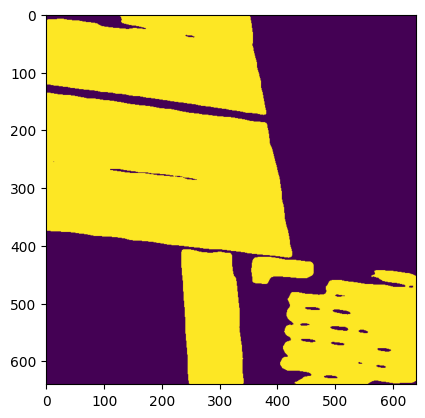

In [18]:
import matplotlib.pyplot as plt
plt.imshow((preds[20] > 0.5).astype(np.uint8))

In [11]:
preds = (preds > 0.5).astype(np.uint8)

In [12]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [13]:
true_list = [list_to_string(rle_encode(ans)) for ans in preds]

predict_df = pd.DataFrame()
predict_df['Id'] = [f'{x:03d}.jpg' for x in range(150)]
predict_df['Target'] = true_list
predict_df.to_csv('submission.csv', index = None)